# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

## Шаг. Откройте файлы с данными

### Загрузка файлов

Здесь будут храниться все импорты за проект (согласно рекомендациям PEP-8):

In [1]:
import matplotlib.pyplot as plt

import numpy 

import pandas as pd

import seaborn as sns

import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

from tqdm import tqdm

In [2]:
df_train_valid = pd.read_csv('/datasets/hotel_train.csv')
df_test = pd.read_csv('/datasets/hotel_test.csv')

### Первичный анализ данных

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:
* `id` — номер записи;
* `adults` — количество взрослых постояльцев;
* `arrival_date_year` — год заезда;
* `arrival_date_month` — месяц заезда;
* `arrival_date_week_number` — неделя заезда;
* `arrival_date_day_of_month` — день заезда;
* `babies` — количество младенцев;
* `booking_changes` — количество изменений параметров заказа;
* `children` — количество детей от 3 до 14 лет;
* `country` — гражданство постояльца;
* `customer_type` — тип заказчика:

        Contract — договор с юридическим лицом;
        Group — групповой заезд;
        Transient — не связано с договором или групповым заездом;
        Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
        
* `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
* `distribution_channel` — канал дистрибуции заказа;
* `is_canceled` — отмена заказа;
* `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
* `lead_time` — количество дней между датой бронирования и датой прибытия;
* `meal` — опции заказа:

        SC — нет дополнительных опций;
        BB — включён завтрак;
        HB — включён завтрак и обед;
        FB — включён завтрак, обед и ужин.
        
* `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
* `previous_cancellations` — количество отменённых заказов у клиента;
* `required_car_parking_spaces` — необходимость места для автомобиля;
* `reserved_room_type` — тип забронированной комнаты;
* `stays_in_weekend_nights` — количество ночей в выходные дни;
* `stays_in_week_nights` — количество ночей в будние дни;
* `total_nights` — общее количество ночей;
* `total_of_special_requests` — количество специальных отметок.

In [3]:
display(df_train_valid.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


In [4]:
df_train_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

В таблице df_train_valid 25 столбцов с типами данных int64, float64 и object, и 65229 строк. 

In [5]:
display(df_test.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

В таблице df_train_valid 25 столбцов с типами данных int64, float64 и object, и 32411 строк.

### Вывод

Тренировочный и тестовый датасеты загружены. Первичный исследовательский анализ не выявил критичных проблем с данными.

## Шаг . Предобработка и исследовательский анализ данных

### Обработка пропусков

Поиск явных пропусков

Тепловая карта пропущенных значений

<AxesSubplot:>

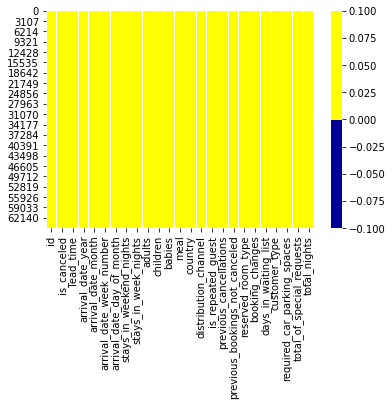

In [7]:
cols = df_train_valid.columns[:1000] 
colours = ['#000099', '#ffff00']
sns.heatmap(df_train_valid[cols].isnull(), cmap=sns.color_palette(colours)) # желтый - пропущенные данные, синий - не пропущенные

На первый взгляд явных пропусков быть не должно, убедимся в этом

In [8]:
print(df_train_valid.isna().sum())

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


In [9]:
print(df_test.isna().sum())

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


Явных пропусков не обнаружено

Изучим неявные пропуски с помощью цикла, пройдясь по всем столбцам и выводя на экран названия столбцов с пропусками и количество пропусков в них:

In [10]:
columns = ['id', 'is_canceled', 'lead_time' ,'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'meal', 'country', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'booking_changes', 'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces', 'total_of_special_requests', "total_nights"]

count = 0
for column in columns:
    if df_train_valid[column].isna().sum() > 0:
        print('Количество пропусков датасета df_train_valid в столбце', column, ':', df_train_valid[column].isna().sum())
        count += 1
if count == 0:
    print('Неявных пропусков в столбцах датасета df_train_valid не обнаружено.')
    
print()

count = 0
for column in columns:
    if df_test[column].isna().sum() > 0:
        print('Количество пропусков датасета df_test в столбце', column, ':', df_test[column].isna().sum())
        count +=1
if count == 0:
    print('Неявных пропусков в столбцах датасета df_test не обнаружено.')

Неявных пропусков в столбцах датасета df_train_valid не обнаружено.

Неявных пропусков в столбцах датасета df_test не обнаружено.


Неявных пропусков нет.

In [11]:
display(df_train_valid.isna().sum().sum())

0

In [12]:
display(df_test.isna().sum().sum())

0

### Обработка дубликатов

Проверка наличия явных дубликатов строк :

In [13]:
print(df_train_valid.duplicated().sum())
print(df_test.duplicated().sum())

0
0


Явных дубликатов нет.
Изучу неявные дубликаты столбца `id`:

In [14]:
print(df_train_valid['id'].duplicated().sum())
print(df_test['id'].duplicated().sum())

0
0


Неявных дубликатов не обнаружено.

In [15]:
display(df_train_valid[df_train_valid.duplicated(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights'])])

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
13,13,0,72.0,2015,July,27,1,2,4,2.0,...,0,0,0,A,1,0,Transient,0,1,6
14,14,0,72.0,2015,July,27,1,2,4,2.0,...,0,0,0,D,1,0,Transient,0,1,6
30,30,0,113.0,2015,July,27,2,2,5,2.0,...,0,0,0,D,0,0,Transient-Party,0,2,7
72,73,0,92.0,2015,July,27,4,4,6,2.0,...,0,0,0,D,0,0,Contract,0,1,10
85,87,1,5.0,2015,July,28,5,1,0,2.0,...,0,0,0,D,0,0,Transient,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65192,83969,0,269.0,2016,December,53,29,2,3,1.0,...,0,0,0,A,0,0,Transient-Party,0,0,5
65193,83970,0,269.0,2016,December,53,29,2,3,1.0,...,0,0,0,A,0,0,Transient-Party,0,1,5
65202,83980,0,291.0,2016,December,53,28,2,4,2.0,...,0,0,0,A,2,0,Transient,0,2,6
65216,84012,0,259.0,2016,December,53,28,2,5,2.0,...,0,0,0,A,3,0,Transient,0,3,7


In [16]:
df_train_valid = df_train_valid.drop_duplicates(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights'], keep='last')

In [17]:
display(df_train_valid)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65224,84057,0,23.0,2016,December,53,30,2,4,2.0,...,0,0,0,D,0,0,Transient,0,2,6
65225,84063,0,53.0,2016,December,53,31,2,3,2.0,...,0,0,0,D,0,0,Transient,0,3,5
65226,84094,0,7.0,2016,December,53,31,2,4,2.0,...,0,0,0,D,0,0,Transient,0,1,6
65227,84117,0,17.0,2016,December,53,30,2,5,2.0,...,0,0,0,A,0,0,Transient,0,1,7


In [18]:
display(df_test[df_test.duplicated(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights'])])

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
34,6121,1,113.0,2017,January,2,8,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
59,6147,1,40.0,2017,January,3,16,1,2,1.0,...,0,0,0,A,0,0,Transient-Party,0,0,3
61,6149,1,40.0,2017,January,3,16,1,2,1.0,...,0,0,0,A,0,0,Transient-Party,0,0,3
63,6151,1,40.0,2017,January,3,16,1,2,1.0,...,0,0,0,A,0,0,Transient-Party,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32377,97869,0,186.0,2017,August,35,31,0,3,2.0,...,0,0,0,D,0,0,Transient,0,2,3
32380,97872,0,63.0,2017,August,35,31,0,3,3.0,...,0,0,0,D,0,0,Transient-Party,0,2,3
32381,97873,0,63.0,2017,August,35,31,0,3,3.0,...,0,0,0,D,0,0,Transient-Party,0,2,3
32382,97874,0,63.0,2017,August,35,31,0,3,3.0,...,0,0,0,D,0,0,Transient-Party,0,2,3


In [19]:
df_test = df_test.drop_duplicates(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights'], keep='last')

In [20]:
display(df_test)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7
5,6091,1,52.0,2017,January,1,1,2,5,1.0,...,0,0,0,A,0,0,Transient,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,97899,0,164.0,2017,August,35,31,2,4,2.0,...,0,0,0,A,0,0,Transient,0,0,6
32408,97900,0,21.0,2017,August,35,30,2,5,2.0,...,0,0,0,A,0,0,Transient,0,2,7
32409,97901,0,23.0,2017,August,35,30,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7
32410,97902,0,34.0,2017,August,35,31,2,5,2.0,...,0,0,0,D,0,0,Transient,0,4,7


### Качественные признаки

Изучу качественные признаки таблиц:

In [21]:
display(df_train_valid.isna().sum().sum())

0

In [22]:
print(df_train_valid['arrival_date_month'].unique())

['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']


In [23]:
print(df_test['arrival_date_month'].unique())

['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']


В тестовых данных нет информации с сентября по декабрь. Это может иметь значение при дальнейшей работе, стоит это учитывать.

In [24]:
print(df_train_valid['meal'].unique())

['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']


In [25]:
print(df_test['meal'].unique())

['BB       ' 'HB       ' 'SC' 'FB       ' 'SC       ']


Кажется, в колонке имеются неявняе дубликаты  повторяющихся значений, а также слова с множеством пробелов.     

In [26]:
print(df_train_valid['country'].unique())

['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'LVA' 'CHL' 'AUT' 'LTU'
 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'TUN' 'ARE'
 'HRV' 'HKG' 'IRN' 'TUR' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT' 'CYP'
 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS' 'MUS'
 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI' 'SGP' 'BDI'
 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT' 'SVK' 'MWI'
 'STP' 'IDN' 'PER' 'KNA' 'ETH' 'SAU' 'ECU' 'IRQ' 'AND' 'SEN' 'TWN' 'HND'
 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN' 'TJK' 'NIC'
 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'BIH' 'TMP' 'GLP' 'KEN' 'LIE' 'MMR'
 'PAN' 'BFA' 'LBY' 'GNB' 'MLI' 'BHR' 'NAM' 'BOL' 'PRY' 'ABW' 'SLV' 'DMA'
 'CUB' 'PYF' 'UGA' 'LCA' 'ATA' 'RWA' 'MNE']


In [27]:
print(df_test['country'].unique())

['PRT' 'AUT' 'BEL' 'DEU' 'BRA' 'GBR' 'ESP' 'FRA' 'ITA' 'LUX' 'CHE' 'EST'
 'NGA' 'IRL' 'CN' 'POL' 'AUS' 'NLD' 'KOR' 'ROU' 'USA' 'CHL' 'DNK' 'FIN'
 'RUS' 'SWE' 'HUN' 'HRV' 'MDV' 'ZAF' 'ISR' 'NOR' 'CHN' 'ARE' 'MAR' 'COL'
 'FJI' 'LVA' 'LBN' 'PHL' 'HKG' 'SYC' 'GIB' 'AGO' 'MYS' 'LTU' 'ISL' 'TUR'
 'ARG' 'JPN' 'SVN' 'SVK' 'BGR' 'CAF' 'JAM' 'UKR' 'IND' 'URY' 'NZL' 'NPL'
 'SRB' 'CPV' 'IRN' 'KAZ' 'IDN' 'BHS' 'SUR' 'CUB' 'PAK' 'MAC' 'CZE' 'CYP'
 'JOR' 'GRC' 'KWT' 'TWN' 'VNM' 'SGP' 'DOM' 'UZB' 'VEN' 'SEN' 'BLR' 'TZA'
 'LIE' 'GNB' 'SAU' 'DZA' 'PER' 'AZE' 'EGY' 'ETH' 'KEN' 'THA' 'MLT' 'ECU'
 'AND' 'IMN' 'BHR' 'TUN' 'MNE' 'MEX' 'BEN' 'MOZ' 'UMI' 'JEY' 'MYT' 'QAT'
 'BGD' 'GAB' 'CIV' 'ZWE' 'GTM' 'ALB' 'GHA' 'ATA' 'ASM' 'PAN' 'CRI' 'MCO'
 'MUS' 'SYR' 'TGO' 'IRQ' 'LKA' 'BIH' 'PRY' 'MRT' 'NCL' 'STP' 'KIR' 'SDN'
 'PRI' 'ATF' 'CMR' 'TJK' 'LBY' 'SLE' 'SLV' 'LAO' 'FRO']


Тут все впорядке!

In [28]:
print(df_train_valid['distribution_channel'].unique())

['Direct' 'TA/TO' 'Corporate' 'GDS']


In [29]:
print(df_test['distribution_channel'].unique())

['TA/TO' 'Direct' 'Corporate' 'GDS']


Все ок

In [30]:
print(df_train_valid['reserved_room_type'].unique())

['A               ' 'C               ' 'D               '
 'E               ' 'G               ' 'F               '
 'B               ']


In [31]:
print(df_test['reserved_room_type'].unique())

['A               ' 'E               ' 'G               '
 'D               ' 'F               ' 'C               '
 'B               ']


In [32]:
print(df_train_valid['customer_type'].unique())

['Transient' 'Contract' 'Transient-Party' 'Group']


In [33]:
print(df_test['customer_type'].unique())

['Transient' 'Transient-Party' 'Contract' 'Group']


Снова обнаружены лишние пробелы. Это может быть связано с особенностями загрузки данных. Пробелы необходимо убрать.
Создам таблицы тренировочных и тестовых данных только с категориальными признаками:

In [34]:
df_train_valid_categorial = df_train_valid[['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']]

In [35]:
df_test_categorial = df_test[['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']]

In [36]:
df_train_valid_categorial = df_train_valid_categorial.stack().str.strip().unstack()

In [37]:
df_test_categorial = df_test_categorial.stack().str.strip().unstack()

Посмотрим, получилось ли убрать пробелы в данных:

In [38]:
print(df_train_valid_categorial['meal'].unique())

['BB' 'FB' 'HB' 'SC']


In [39]:
print(df_test_categorial['meal'].unique())

['BB' 'HB' 'SC' 'FB']


In [40]:
print(df_train_valid_categorial['reserved_room_type'].unique())

['A' 'C' 'D' 'E' 'G' 'F' 'B']


In [41]:
print(df_test_categorial['reserved_room_type'].unique())

['A' 'E' 'G' 'D' 'F' 'C' 'B']


Пробелы ликвидированы.

### Количественные признаки

In [42]:
display(df_train_valid.isna().sum().sum())

0

In [43]:
display(df_train_valid[df_train_valid['adults'] == 0])

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
17540,25480,0,1.0,2015,August,33,10,1,1,0.0,...,0,0,0,B,1,0,Transient-Party,0,0,2
17598,25538,0,104.0,2015,August,33,11,0,3,0.0,...,0,0,0,B,1,0,Transient-Party,0,2,3
17982,25922,0,3.0,2015,August,34,16,2,0,0.0,...,0,0,0,B,1,0,Transient-Party,0,1,2
21556,29496,1,48.0,2015,October,43,19,1,3,0.0,...,0,0,0,B,0,0,Transient-Party,0,1,4
22516,30456,1,6.0,2015,December,51,13,1,0,0.0,...,0,0,0,B,0,0,Transient-Party,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64751,83478,0,197.0,2016,December,52,21,1,4,0.0,...,0,0,0,A,7,0,Transient-Party,0,0,5
64882,83610,0,104.0,2016,December,53,25,2,1,0.0,...,0,0,0,B,1,0,Transient,0,2,3
64892,83620,0,104.0,2016,December,53,25,2,1,0.0,...,0,0,0,B,0,0,Transient,0,2,3
64903,83633,0,247.0,2016,December,52,24,2,3,0.0,...,0,0,0,B,0,0,Transient,0,1,5


Изучаю количественные данные:

In [44]:
print(df_train_valid.columns)

Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights'],
      dtype='object')


Для удобства исследования создам отдельные таблицы с количественными признаками.

In [45]:
df_train_valid_quantitative = df_train_valid[['id', 'is_canceled', 'lead_time' ,'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', "total_nights"]]
df_test_quantitative = df_test[['id', 'is_canceled', 'lead_time' ,'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', "total_nights"]]


In [46]:
display(df_train_valid.isna().sum().sum())

0

In [47]:
pd.set_option('display.max_columns', None)
display(df_train_valid_quantitative.head(10))

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,27,1,0,1,1.0,0.0,0.0,0,0,0,0,0,0,0,1
1,1,0,14.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,1,2
2,2,0,0.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,0,2
3,3,0,9.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,1,2
4,4,1,85.0,2015,27,1,0,3,2.0,0.0,0.0,0,0,0,0,0,0,1,3
5,5,1,75.0,2015,27,1,0,3,2.0,0.0,0.0,0,0,0,0,0,0,0,3
6,6,1,23.0,2015,27,1,0,4,2.0,0.0,0.0,0,0,0,0,0,0,0,4
7,7,0,18.0,2015,27,1,0,4,2.0,1.0,0.0,0,0,0,1,0,0,1,4
8,8,0,68.0,2015,27,1,0,4,2.0,0.0,0.0,0,0,0,0,0,0,3,4
9,9,0,37.0,2015,27,1,0,4,2.0,0.0,0.0,0,0,0,0,0,0,0,4


In [48]:
display(df_train_valid.isna().sum().sum())

0

Изучу уникальные значения некоторых столбцов:

In [49]:
columns = ['is_canceled', 'arrival_date_year', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'required_car_parking_spaces', 'total_of_special_requests', "total_nights"]
for column in columns:
    print('Уникальные значения в столбце', column, ':', df_train_valid_quantitative[column].unique())
print()
for column in columns:
    print('Уникальные значения в столбце', column, ':', df_test_quantitative[column].unique())

Уникальные значения в столбце is_canceled : [0 1]
Уникальные значения в столбце arrival_date_year : [2015 2016]
Уникальные значения в столбце stays_in_weekend_nights : [0 2 1 4 3]
Уникальные значения в столбце stays_in_week_nights : [1 2 3 4 5 6 0]
Уникальные значения в столбце adults : [1. 2. 3. 4. 0.]
Уникальные значения в столбце children : [0. 1. 2. 3.]
Уникальные значения в столбце babies : [ 0.  1.  2. 10.  9.]
Уникальные значения в столбце is_repeated_guest : [0 1]
Уникальные значения в столбце required_car_parking_spaces : [0 1 2 3]
Уникальные значения в столбце total_of_special_requests : [0 1 3 2 4 5]
Уникальные значения в столбце total_nights : [ 1  2  3  4  6  7  5  8 10  9]

Уникальные значения в столбце is_canceled : [1 0]
Уникальные значения в столбце arrival_date_year : [2017]
Уникальные значения в столбце stays_in_weekend_nights : [1 2 0 4 3]
Уникальные значения в столбце stays_in_week_nights : [0 2 5 1 3 4 6]
Уникальные значения в столбце adults : [2. 1. 3. 4. 0.]
Уни

Странные значения Обнаружены в столбце признака `babies`, когда одновременно заселяются 9 и 10 младенцев. Исследую подробнее данные строки:

In [50]:
display(df_train_valid_quantitative[df_train_valid_quantitative['babies'] > 3])

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
22995,30935,0,37.0,2016,3,12,0,2,2.0,0.0,10.0,0,0,0,1,0,0,1,2
41528,59925,0,11.0,2015,42,11,2,1,1.0,0.0,9.0,0,0,0,1,0,0,0,3


Взрослых мало, похоже на ошибку. Строки можно удалить

In [51]:
display(df_test_quantitative[(df_test_quantitative['babies'] > 0) & (df_test_quantitative['adults'] == 0)])

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights


In [52]:
display(df_test_quantitative[(df_test['children'] > 0) & (df_test_quantitative['adults'] == 0)].head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
7743,44932,1,111.0,2017,1,2,1,3,0.0,2.0,0.0,0,0,0,0,0,0,2,4
7751,44940,1,268.0,2017,1,2,1,4,0.0,2.0,0.0,0,0,0,0,0,0,1,5
8772,45961,1,148.0,2017,6,5,2,5,0.0,2.0,0.0,0,0,0,0,0,0,2,7
9243,46432,1,134.0,2017,8,22,2,4,0.0,2.0,0.0,0,0,0,0,0,0,1,6
9305,46494,1,148.0,2017,8,24,2,2,0.0,2.0,0.0,0,0,0,1,0,0,1,4


In [53]:
display(df_test_quantitative[(df_test_quantitative['children'] > 1) & (df_test_quantitative['adults'] == 0)].shape[:1])

(56,)

In [54]:
display(df_test_quantitative[(df_test['children'] > 0) & (df_test_quantitative['adults'] == 0)]['children'].sum())

116.0

124 детей заехали без родителей  - это ошибки. Данные строки следует удалить из выбоки.

In [55]:
display(df_train_valid_quantitative[(df_train_valid_quantitative['babies'] > 0) & (df_train_valid_quantitative['adults'] == 0)])

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
22534,30474,0,6.0,2015,51,18,0,1,0.0,2.0,1.0,0,0,0,0,0,0,2,1
44049,62477,1,22.0,2015,50,9,1,4,0.0,2.0,1.0,0,0,0,1,0,0,1,5
52923,71499,0,14.0,2016,24,9,0,3,0.0,2.0,1.0,0,0,0,2,0,0,2,3


In [56]:
display(df_train_valid_quantitative[(df_train_valid_quantitative['babies'] > 0) & (df_train_valid_quantitative['adults'] == 0)].shape[:1])

(3,)

In [57]:
display(df_train_valid_quantitative[(df_train_valid_quantitative['babies'] > 0) & (df_train_valid_quantitative['adults'] == 0)]['babies'].sum())

3.0

В тренировочной выборке 3 младенца заселились без взрослых - явный выброс

In [58]:
display(df_train_valid_quantitative[(df_train_valid_quantitative['children'] > 0) & (df_train_valid_quantitative['adults'] == 0)].head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
17540,25480,0,1.0,2015,33,10,1,1,0.0,3.0,0.0,0,0,0,1,0,0,0,2
17598,25538,0,104.0,2015,33,11,0,3,0.0,2.0,0.0,0,0,0,1,0,0,2,3
17982,25922,0,3.0,2015,34,16,2,0,0.0,2.0,0.0,0,0,0,1,0,0,1,2
21556,29496,1,48.0,2015,43,19,1,3,0.0,2.0,0.0,0,0,0,0,0,0,1,4
22516,30456,1,6.0,2015,51,13,1,0,0.0,3.0,0.0,0,0,0,0,0,0,1,1


In [59]:
display(df_train_valid_quantitative[(df_train_valid_quantitative['children'] > 0) & (df_train_valid_quantitative['adults'] == 0)].shape[:1])

(148,)

In [60]:
display(df_train_valid_quantitative[(df_train_valid_quantitative['children'] > 0) & (df_train_valid_quantitative['adults'] == 0)]['children'].sum())

302.0

308 детей забронировали отель без родителей - ошибки

Удалю некорректные объекты:

In [61]:
display(df_train_valid_quantitative[df_train_valid_quantitative['adults'] == 0])

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
17540,25480,0,1.0,2015,33,10,1,1,0.0,3.0,0.0,0,0,0,1,0,0,0,2
17598,25538,0,104.0,2015,33,11,0,3,0.0,2.0,0.0,0,0,0,1,0,0,2,3
17982,25922,0,3.0,2015,34,16,2,0,0.0,2.0,0.0,0,0,0,1,0,0,1,2
21556,29496,1,48.0,2015,43,19,1,3,0.0,2.0,0.0,0,0,0,0,0,0,1,4
22516,30456,1,6.0,2015,51,13,1,0,0.0,3.0,0.0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64751,83478,0,197.0,2016,52,21,1,4,0.0,3.0,0.0,0,0,0,7,0,0,0,5
64882,83610,0,104.0,2016,53,25,2,1,0.0,2.0,0.0,0,0,0,1,0,0,2,3
64892,83620,0,104.0,2016,53,25,2,1,0.0,2.0,0.0,0,0,0,0,0,0,2,3
64903,83633,0,247.0,2016,52,24,2,3,0.0,2.0,0.0,0,0,0,0,0,0,1,5


В этих номерах нет ни взроcлых ни детей:

In [62]:
pd.set_option('display.max_columns', None)

display(df_train_valid_quantitative[(df_train_valid_quantitative['adults'] == 0) & (df_train_valid_quantitative['children'] == 0) & (df_train_valid_quantitative['babies'] == 0)].shape[:1])

(14,)

В этих номерах нет взрослых, но есть младенцы или дети:

In [63]:
display(df_train_valid_quantitative[(df_train_valid_quantitative['adults'] == 0) & ((df_train_valid_quantitative['children'] != 0) | (df_train_valid_quantitative['babies'] != 0))].shape[:1])

(148,)

В этих номерах нет взрослых, но есть и младенцы и дети:

In [64]:
display(df_train_valid_quantitative[(df_train_valid_quantitative['adults'] == 0) & ((df_train_valid_quantitative['children'] != 0) & (df_train_valid_quantitative['babies'] != 0))].shape[:1])

(3,)

Всего номеров без взрослых:

In [65]:
display(df_train_valid_quantitative[df_train_valid_quantitative['adults'] == 0].shape[:1])

(162,)

Оставим только те строки, в которых дети и младенцы присутствуют только со взрослыми:

Длинна таблицы до преобразования:

In [66]:
df_train_valid_quantitative.shape[:1]

(41390,)

In [67]:
df_train_valid_quantitative = df_train_valid_quantitative[df_train_valid_quantitative['adults'] != 0]

In [68]:
display(df_train_valid_quantitative.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,27,1,0,1,1.0,0.0,0.0,0,0,0,0,0,0,0,1
1,1,0,14.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,1,2
2,2,0,0.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,0,2
3,3,0,9.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,1,2
4,4,1,85.0,2015,27,1,0,3,2.0,0.0,0.0,0,0,0,0,0,0,1,3


In [69]:
df_train_valid_quantitative.shape[:1]

(41228,)

In [70]:
display(df_train_valid_quantitative[(df_train_valid_quantitative['adults'] == 0) & (df_train_valid_quantitative['children'] == 0) & (df_train_valid_quantitative['babies'] == 0)].shape[:1])

(0,)

In [71]:
display(df_train_valid_quantitative[(df_train_valid_quantitative['adults'] == 0) & ((df_train_valid_quantitative['children'] != 0) | (df_train_valid_quantitative['babies'] != 0))].shape[:1])

(0,)

In [72]:
display(df_train_valid_quantitative[(df_train_valid_quantitative['adults'] == 0) & ((df_train_valid_quantitative['children'] != 0) & (df_train_valid_quantitative['babies'] != 0))].shape[:1])

(0,)

In [73]:
display(df_train_valid_quantitative[df_train_valid_quantitative['adults'] == 0].shape[:1])

(0,)

In [74]:
display(df_train_valid_quantitative[df_train_valid_quantitative['adults'] > 4]['adults'].shape)

(0,)

Выбросов в столбце взрослых необнаружено.

Все некорректные строки без взрослых и с выбросами в столбцах детей - удалены

Остальные признаки удобнее проанализировать графически:

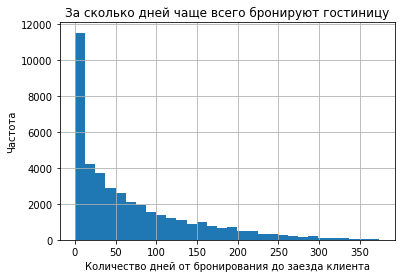

In [75]:
plt_train_valid_quantitative = df_train_valid_quantitative['lead_time'].hist(bins=30)

plt.xlabel('Количество дней от бронирования до заезда клиента') # подписи осей
plt.ylabel('Частота')
plt.title('За сколько дней чаще всего бронируют гостиницу') # заголовок
plt.show()

На графике виден высокий пик около нуля. Вряд ли такое количество гостей бронирует отель за 0 дней. Посмотрим на ящик с усами для данного признака:

<AxesSubplot:>

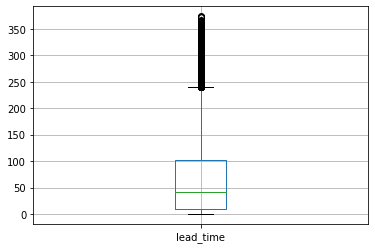

In [76]:
pd.DataFrame(df_train_valid_quantitative['lead_time']).boxplot()


In [77]:
print(df_train_valid_quantitative['lead_time'].describe())

count    41228.000000
mean        67.816072
std         73.329388
min          0.000000
25%         10.000000
50%         42.000000
75%        102.000000
max        374.000000
Name: lead_time, dtype: float64


Cреднее почти в два раза больше медианы - в распределении признака есть длинный хвост или несколько больших значений. Гипотиза с выбросами возле нуля не подтвердилась - скорее всего большое  количество клиентов действительно брониует номера вплотную к дате заселения.

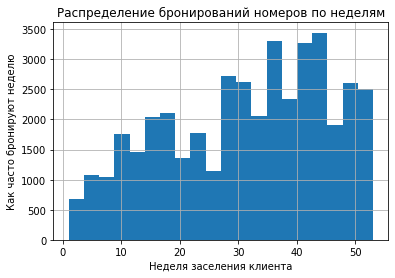

In [78]:
plt_train_valid_quantitative = df_train_valid_quantitative['arrival_date_week_number'].hist(bins=20)

plt.xlabel('Неделя заселения клиента') # подписи осей
plt.ylabel('Как часто бронируют неделю')
plt.title('Распределение бронирований номеров по неделям') # заголовок
plt.show()

Пик бронирований приходится на лето, ближе к августу.

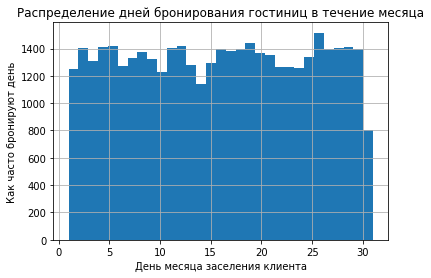

In [79]:
plt_train_valid_quantitative = df_train_valid_quantitative['arrival_date_day_of_month'].hist(bins=31)

plt.xlabel('День месяца заселения клиента') # подписи осей
plt.ylabel('Как часто бронируют день')
plt.title('Распределение дней бронирования гостиниц в течение месяца') # заголовок
plt.show()

Выбросов нет

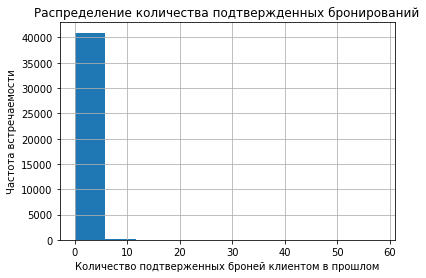

In [80]:
plt_train_valid_quantitative = df_train_valid_quantitative['previous_bookings_not_canceled'].hist(bins=10)

plt.xlabel('Количество подтверженных броней клиентом в прошлом') # подписи осей
plt.ylabel('Частота встречаемости')
plt.title('Распределение количества подтвержденных бронирований') # заголовок
plt.show()

изучу подробнее данные с  отмененными бронями:

In [81]:
print(df_train_valid_quantitative['previous_bookings_not_canceled'].value_counts())
print('Максимальное количество подтвержденных броней одним клиентом:', df_train_valid_quantitative['previous_bookings_not_canceled'].max())

0     39761
1       583
2       250
3       133
4       113
5        89
6        55
7        34
8        25
9        23
10       21
11       16
12       14
13        9
21        8
14        8
22        7
15        7
16        6
20        5
19        5
18        5
17        5
27        3
25        3
24        3
29        2
28        2
44        2
23        2
48        2
40        1
55        1
54        1
56        1
53        1
57        1
26        1
58        1
30        1
33        1
51        1
34        1
52        1
41        1
50        1
49        1
47        1
32        1
35        1
45        1
36        1
37        1
43        1
38        1
42        1
39        1
31        1
Name: previous_bookings_not_canceled, dtype: int64
Максимальное количество подтвержденных броней одним клиентом: 58


In [82]:
display(df_train_valid_quantitative[df_train_valid_quantitative['previous_bookings_not_canceled'] < 1])

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,27,1,0,1,1.0,0.0,0.0,0,0,0,0,0,0,0,1
1,1,0,14.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,1,2
2,2,0,0.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,0,2
3,3,0,9.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,1,2
4,4,1,85.0,2015,27,1,0,3,2.0,0.0,0.0,0,0,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65224,84057,0,23.0,2016,53,30,2,4,2.0,0.0,0.0,0,0,0,0,0,0,2,6
65225,84063,0,53.0,2016,53,31,2,3,2.0,0.0,0.0,0,0,0,0,0,0,3,5
65226,84094,0,7.0,2016,53,31,2,4,2.0,0.0,0.0,0,0,0,0,0,0,1,6
65227,84117,0,17.0,2016,53,30,2,5,2.0,0.0,0.0,0,0,0,0,0,0,1,7


Большинство клиентов ранее не бронировали номера, поэтому у них нет предыдущих подтвержденных броней. Но есть и постоянные клиенты, кто бронировал 58 раз.

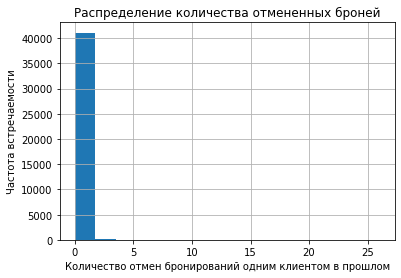

In [83]:
plt_train_valid_quantitative = df_train_valid_quantitative['previous_cancellations'].hist(bins=15)

plt.xlabel('Количество отмен бронирований одним клиентом в прошлом') # подписи осей
plt.ylabel('Частота встречаемости')
plt.title('Распределение количества отмененных броней') # заголовок
plt.show()

Большинство не отменяли бронирование, но малая доля клиентов отменяла, изучу подробнее:

In [84]:
display('Отменяли бронирование хотя бы раз:', df_train_valid_quantitative[df_train_valid_quantitative['previous_cancellations'] > 0]['previous_cancellations'].count())

'Отменяли бронирование хотя бы раз:'

1134

In [85]:
display('Отменяли бронирование более 2 раз:', df_train_valid_quantitative[df_train_valid_quantitative['previous_cancellations'] > 1]['previous_cancellations'].count())

'Отменяли бронирование более 2 раз:'

155

In [86]:
display('Отменяли бронирование более 3 раз:', df_train_valid_quantitative[df_train_valid_quantitative['previous_cancellations'] > 3]['previous_cancellations'].count())

'Отменяли бронирование более 3 раз:'

57

In [87]:
display('Отменяли бронирование более 25 раз:', df_train_valid_quantitative[df_train_valid_quantitative['previous_cancellations'] > 25]['previous_cancellations'].count())

'Отменяли бронирование более 25 раз:'

1

In [88]:
display(df_train_valid_quantitative[df_train_valid_quantitative['previous_cancellations'] == 26])

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
6290,8619,1,275.0,2015,41,4,2,0,2.0,0.0,0.0,0,26,0,0,0,0,0,2


Данные строки похожи на дубликаты, которые относятся к одному и тому же клиенту. Эти дубликаты стоит удалить, кроме одного

In [89]:
display(df_train_valid_quantitative.columns)

Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights'],
      dtype='object')

In [90]:
display(df_train_valid_quantitative)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,27,1,0,1,1.0,0.0,0.0,0,0,0,0,0,0,0,1
1,1,0,14.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,1,2
2,2,0,0.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,0,2
3,3,0,9.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,1,2
4,4,1,85.0,2015,27,1,0,3,2.0,0.0,0.0,0,0,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65224,84057,0,23.0,2016,53,30,2,4,2.0,0.0,0.0,0,0,0,0,0,0,2,6
65225,84063,0,53.0,2016,53,31,2,3,2.0,0.0,0.0,0,0,0,0,0,0,3,5
65226,84094,0,7.0,2016,53,31,2,4,2.0,0.0,0.0,0,0,0,0,0,0,1,6
65227,84117,0,17.0,2016,53,30,2,5,2.0,0.0,0.0,0,0,0,0,0,0,1,7


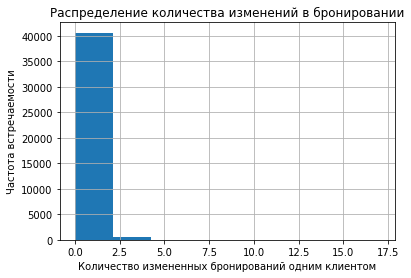

In [91]:
plt_train_valid_quantitative = df_train_valid_quantitative['booking_changes'].hist(bins=8)

plt.xlabel('Количество измененных бронирований одним клиентом') # подписи осей
plt.ylabel('Частота встречаемости')
plt.title('Распределение количества изменений в бронировании') # заголовок
plt.show()

In [92]:
print(df_train_valid_quantitative['booking_changes'].value_counts())

0     34123
1      5019
2      1494
3       359
4       135
5        39
6        18
7        17
8         7
9         5
13        4
10        2
14        2
15        2
16        1
17        1
Name: booking_changes, dtype: int64


Большинство не меняет бронирований, примерно в 10 процентах менят бронь один раз, остальные - относительно редко.

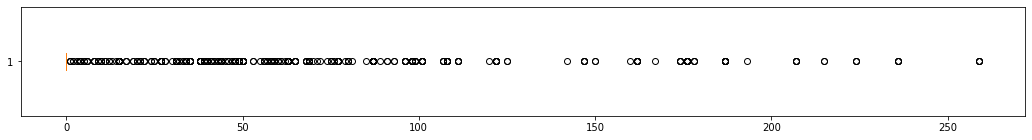

In [93]:
plt.figure(figsize=(18, 2))
plt.boxplot(df_train_valid_quantitative['days_in_waiting_list'], vert=False)
plt.show()

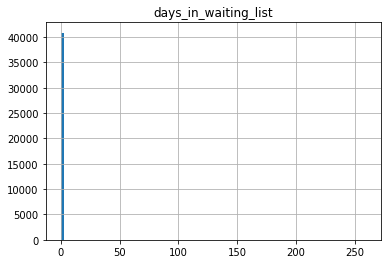

In [94]:
pd.DataFrame(df_train_valid_quantitative['days_in_waiting_list']).hist(bins=100)
plt.show()

In [95]:
df_train_valid_quantitative['days_in_waiting_list'].shape

(41228,)

Большое количество выбросов при нулевом ящике выглядит странно. Отклонения численных признаков могут быть слишком четкими, чтобы не визуализироваться коробчатой диаграммой. Вместо этого попробую проанализировать их описательную статистику:

In [96]:
print(df_train_valid_quantitative['days_in_waiting_list'].describe())

count    41228.000000
mean         0.683856
std          8.922310
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        259.000000
Name: days_in_waiting_list, dtype: float64


In [97]:
print(df_train_valid_quantitative['days_in_waiting_list'].value_counts())

0      40841
63        20
87        17
15        13
44        12
       ...  
13         1
45         1
160        1
79         1
14         1
Name: days_in_waiting_list, Length: 97, dtype: int64


Большая часть значений - нулевые, поэтому такая картина ящика с усами - болльшинству клиентов нет необходимости ждать бронирования. Все остальные значения. кроме нулей - это нестандартные случаи.

Некоторые целочисленные данные отображены в формате чисел с плавающей точкой:

In [98]:
df_test_quantitative[['lead_time', 'adults', 'children']].head()

,lead_time,adults,children
0,74.0,2.0,0.0
2,62.0,2.0,0.0
3,71.0,1.0,0.0
4,172.0,2.0,0.0
5,52.0,1.0,0.0


In [99]:
df_test_quantitative.shape

(23712, 19)

 Исправлю это:

In [100]:
pd.options.mode.chained_assignment = None  # default='warn' - отключиила предупреждения о перезаписи данных

In [101]:
for column in df_test_quantitative[['lead_time', 'adults', 'children']]:
    df_test_quantitative[column] = df_test_quantitative[column].astype('int64')
    print('Тип данных в тренировочном датасете признака', column, ':', df_test_quantitative[column].dtype)

Тип данных в тренировочном датасете признака lead_time : int64
Тип данных в тренировочном датасете признака adults : int64
Тип данных в тренировочном датасете признака children : int64


Типы данных в `df_test_quantitative` исправлены.
Исправлю типы данных в  датафрейме `df_train_valid_quantitative`:

In [102]:
for column in df_train_valid_quantitative[['lead_time', 'adults', 'children']]:
    df_train_valid_quantitative[column] = df_train_valid_quantitative[column].astype('int64')
    print('Тип данных в тестовом датасете признака', column, ':', df_train_valid_quantitative[column].dtype)

Тип данных в тестовом датасете признака lead_time : int64
Тип данных в тестовом датасете признака adults : int64
Тип данных в тестовом датасете признака children : int64


Типы данных в `df_train_valid_quantitative` исправлены.

In [103]:
df_train_valid_quantitative.shape

(41228, 19)

In [104]:
display(df_train_valid_quantitative[['total_nights', 'stays_in_week_nights', 'stays_in_weekend_nights']])

,total_nights,stays_in_week_nights,stays_in_weekend_nights
0,1,1,0
1,2,2,0
2,2,2,0
3,2,2,0
4,3,3,0
...,...,...,...
65224,6,4,2
65225,5,3,2
65226,6,4,2
65227,7,5,2


Изучу дублирует ли сумма столбцов `stays_in_week_nights` и `stays_in_weekend_nights` столбец `total_nights`:

In [105]:
df_train_valid_quantitative['is_equal'] = numpy.where((df_train_valid_quantitative['stays_in_week_nights'] + df_train_valid_quantitative['stays_in_weekend_nights']) == df_train_valid_quantitative['total_nights'], True, False)

In [106]:
print('Число строк, в которых stays_in_week_nights + stays_in_weekend_nights НЕ равно total_nights:', df_train_valid_quantitative[df_train_valid_quantitative['is_equal'] == False]['is_equal'].count())

Число строк, в которых stays_in_week_nights + stays_in_weekend_nights НЕ равно total_nights: 0


Таким образом сумма двух столбцов равна третьему стоблцу. Столбцы `stays_in_week_nights` и `stays_in_weekend_nights` можно удалить:

In [107]:
df_train_valid_quantitative = df_train_valid_quantitative.drop(['stays_in_week_nights', 'stays_in_weekend_nights', 'is_equal'], axis=1)

In [108]:
display(df_train_valid_quantitative.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7,2015,27,1,1,0,0.0,0,0,0,0,0,0,0,1
1,1,0,14,2015,27,1,2,0,0.0,0,0,0,0,0,0,1,2
2,2,0,0,2015,27,1,2,0,0.0,0,0,0,0,0,0,0,2
3,3,0,9,2015,27,1,2,0,0.0,0,0,0,0,0,0,1,2
4,4,1,85,2015,27,1,2,0,0.0,0,0,0,0,0,0,1,3


Лишние столбцы удалены.

### Вывод

Данные исследованы на предмет пропусков и дубликатов. Были обнаружены неявные дубликаты в столбцах 'reserved_room_type' и 'meal', в данных обнаружены пробелы, которые были устранены. В количественных данных были откорректированы типы данных.

## Шаг. Формулировка ML-задачи на основе бизнес-задачи

В данном разделе необходимо оценить прибыль отеля без внедрения депозитов.

**Прибыль отеля =  стоимость номера * все ночи - затраты на обслуживание каждые два дня с учетом сезонного коэфициента**

Константы:

Бюджет на разработку системы прогнозирования:

In [109]:
display(df_train_valid.isna().sum().sum())

0

In [110]:
BUDGET = 400000

In [111]:
display(df_train_valid.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


Для того, чтобы узнать прибыль отеля, необходимо знать стоимость номеров. Это проще всего сделать через функцию, применив ее к типу резервируемой комнаты.

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.


В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.


    Стоимость номеров отеля:
    * категория A: за ночь — 1 000, разовое обслуживание — 400;
    * категория B: за ночь — 800, разовое обслуживание — 350;
    * категория C: за ночь — 600, разовое обслуживание — 350;
    * категория D: за ночь — 550, разовое обслуживание — 150;
    * категория E: за ночь — 500, разовое обслуживание — 150;
    * категория F: за ночь — 450, разовое обслуживание — 150;
    * категория G: за ночь — 350, разовое обслуживание — 150.


В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.


Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. 

При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период.

Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Функция для определения стоимости номера:

In [112]:
def room_cost_is(category):
    if category == 'A':
        return 1000
    elif category == 'B':
        return 800
    elif category == 'C':
        return 600
    elif category == 'D':
        return 550
    elif category == 'E':
        return 500
    elif category == 'F':
        return 450
    elif category == 'G':
        return 350

In [113]:
df_train_valid = df_train_valid_categorial.join(df_train_valid_quantitative, how='inner')
df_train_valid['room_cost'] = df_train_valid['reserved_room_type'].apply(room_cost_is)

df_test = df_test_categorial.join(df_test_quantitative)
df_test['room_cost'] = df_test['reserved_room_type'].apply(room_cost_is)

In [114]:
display(df_train_valid.isna().sum().sum())

0

In [115]:
display(df_train_valid.head())

,arrival_date_month,meal,country,distribution_channel,reserved_room_type,customer_type,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,room_cost
0,July,BB,GBR,Direct,A,Transient,0,0,7,2015,27,1,1,0,0.0,0,0,0,0,0,0,0,1,1000
1,July,BB,GBR,TA/TO,A,Transient,1,0,14,2015,27,1,2,0,0.0,0,0,0,0,0,0,1,2,1000
2,July,BB,PRT,Direct,C,Transient,2,0,0,2015,27,1,2,0,0.0,0,0,0,0,0,0,0,2,600
3,July,FB,PRT,Direct,C,Transient,3,0,9,2015,27,1,2,0,0.0,0,0,0,0,0,0,1,2,600
4,July,BB,PRT,TA/TO,A,Transient,4,1,85,2015,27,1,2,0,0.0,0,0,0,0,0,0,1,3,1000


In [116]:
display(df_test.head())

,arrival_date_month,meal,country,distribution_channel,reserved_room_type,customer_type,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,room_cost
0,January,BB,PRT,TA/TO,A,Transient,6086,1,74,2017,1,1,1,0,2,0,0.0,0,0,0,0,0,0,0,1,1000
2,January,BB,AUT,TA/TO,A,Transient,6088,1,62,2017,1,1,2,2,2,0,0.0,0,0,0,0,0,0,1,4,1000
3,January,BB,PRT,TA/TO,A,Transient,6089,1,71,2017,1,1,2,2,1,0,0.0,0,0,0,0,0,0,1,4,1000
4,January,BB,BEL,TA/TO,A,Transient,6090,1,172,2017,1,1,2,5,2,0,0.0,0,0,0,0,0,0,0,7,1000
5,January,BB,DEU,TA/TO,A,Transient,6091,1,52,2017,1,1,2,5,1,0,0.0,0,0,0,0,0,0,0,7,1000


Теперь проиндексирую стоимость номеров в соответствии с сезоном:

In [117]:
def season_room_cost(line):
    spring = ['March', 'April', 'May']
    summer = ['June', 'July', 'August']
    autumn = ['September', 'October', 'November']
    month = line['arrival_date_month']
    if (month in spring) or (month in autumn):
        return line['room_cost'] + line['room_cost'] * 0.2
    elif month in summer:
        return line['room_cost'] + line['room_cost'] * 0.4
    else:
        return line['room_cost']

In [118]:
df_test['seasonal_room_cost'] = df_test.apply(season_room_cost, axis=1)
df_test.pop('room_cost')

0        1000
2        1000
3        1000
4        1000
5        1000
         ... 
32407    1000
32408    1000
32409    1000
32410     550
32411    1000
Name: room_cost, Length: 23712, dtype: int64

In [119]:
display(df_test.head())

,arrival_date_month,meal,country,distribution_channel,reserved_room_type,customer_type,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,seasonal_room_cost
0,January,BB,PRT,TA/TO,A,Transient,6086,1,74,2017,1,1,1,0,2,0,0.0,0,0,0,0,0,0,0,1,1000.0
2,January,BB,AUT,TA/TO,A,Transient,6088,1,62,2017,1,1,2,2,2,0,0.0,0,0,0,0,0,0,1,4,1000.0
3,January,BB,PRT,TA/TO,A,Transient,6089,1,71,2017,1,1,2,2,1,0,0.0,0,0,0,0,0,0,1,4,1000.0
4,January,BB,BEL,TA/TO,A,Transient,6090,1,172,2017,1,1,2,5,2,0,0.0,0,0,0,0,0,0,0,7,1000.0
5,January,BB,DEU,TA/TO,A,Transient,6091,1,52,2017,1,1,2,5,1,0,0.0,0,0,0,0,0,0,0,7,1000.0


In [120]:
def room_cost_is(category):
    if category == 'A':
        return 1000
    elif category == 'B':
        return 800 
    elif category == 'C':
        return 600
    elif category == 'D':
        return 550
    elif category == 'E':
        return 500
    elif category == 'F':
        return 450
    elif category == 'G':
        return 350

In [121]:
df_train_valid['seasonal_room_cost'] = df_train_valid.apply(season_room_cost, axis=1)
df_train_valid.pop('room_cost')

0        1000
1        1000
2         600
3         600
4        1000
         ... 
65224     550
65225     550
65226     550
65227    1000
65228    1000
Name: room_cost, Length: 41228, dtype: int64

In [122]:
display(df_train_valid.head())

,arrival_date_month,meal,country,distribution_channel,reserved_room_type,customer_type,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,seasonal_room_cost
0,July,BB,GBR,Direct,A,Transient,0,0,7,2015,27,1,1,0,0.0,0,0,0,0,0,0,0,1,1400.0
1,July,BB,GBR,TA/TO,A,Transient,1,0,14,2015,27,1,2,0,0.0,0,0,0,0,0,0,1,2,1400.0
2,July,BB,PRT,Direct,C,Transient,2,0,0,2015,27,1,2,0,0.0,0,0,0,0,0,0,0,2,840.0
3,July,FB,PRT,Direct,C,Transient,3,0,9,2015,27,1,2,0,0.0,0,0,0,0,0,0,1,2,840.0
4,July,BB,PRT,TA/TO,A,Transient,4,1,85,2015,27,1,2,0,0.0,0,0,0,0,0,0,1,3,1400.0


Посчитаю затраты на обслуживание номеров.

In [123]:
# Затраты на обслуживание до сезонной индексации
def room_service_is(category):
    if category == 'A':
        return 400
    elif category == 'B':
        return 350
    elif category == 'C':
        return 350
    elif category == 'D':
        return 150
    elif category == 'E':
        return 150
    elif category == 'F':
        return 150
    elif category == 'G':
        return 150

In [124]:
df_train_valid['room_service'] = df_train_valid['reserved_room_type'].apply(room_service_is) 
df_test['room_service'] = df_test['reserved_room_type'].apply(room_service_is) 

In [125]:
# Затраты на обслуживание после сезонной индексации
def season_room_service(line):
    spring = ['March', 'April', 'May']
    summer = ['June', 'July', 'August']
    autumn = ['September', 'October', 'November']
    month = line['arrival_date_month']
    if (month in spring) or (month in autumn):
        return (line['room_service'] + line['room_service'] * 0.2)
    elif month in summer:
        return (line['room_service'] + line['room_service'] * 0.4) 
    else:
        return line['room_service']

In [126]:
df_train_valid['season_room_service'] = df_train_valid.apply(season_room_service, axis=1)

df_train_valid.pop('room_service')
df_test['season_room_service'] = df_test.apply(season_room_service, axis=1)
df_test.pop('room_service')

0        400
2        400
3        400
4        400
5        400
        ... 
32407    400
32408    400
32409    400
32410    150
32411    400
Name: room_service, Length: 23712, dtype: int64

Посчитаю прибыль до внедрения депозита:

In [127]:
def correct_profit(row):

    if row['is_canceled'] == 0:
        revenue = row['seasonal_room_cost'] * row['total_nights'] 
        expenses = row['season_room_service'] * (1 + row['total_nights'] // 2)
        
        rslt = revenue - expenses
        
    else:
        revenue = - row['seasonal_room_cost']
        expenses = row['season_room_service']
        
        rslt = revenue - expenses

    return rslt

df_train_valid['profit_before_deposit'] = df_train_valid.apply(correct_profit, axis=1)
df_test['profit_before_deposit'] = df_test.apply(correct_profit, axis=1)


#итоговая прибыль
print('Итоговая прибыль за тестовый период до внедрения депозита', df_test['profit_before_deposit'].sum())
display('Пример рассчитанной прибыли, если бронь подтверждена:', df_test[df_test['is_canceled'] == 0]['profit_before_deposit'].head())
display('Пример рассчитанной прибыли, если бронь отменена:', df_test[df_test['is_canceled'] == 1]['profit_before_deposit'].head())

Итоговая прибыль за тестовый период до внедрения депозита 27841160.0


'Пример рассчитанной прибыли, если бронь подтверждена:'

95       600.0
299     2800.0
2041     840.0
2125    2200.0
2126     600.0
Name: profit_before_deposit, dtype: float64

'Пример рассчитанной прибыли, если бронь отменена:'

0   -1400.0
2   -1400.0
3   -1400.0
4   -1400.0
5   -1400.0
Name: profit_before_deposit, dtype: float64

**Формулировка мл-задачи:** необходимо разработать такую модель, которая сможет эффективно предсказывать отмену брони на основании имеющихся данных клиентов. Мерой эффективности в данном случае служит прибыль отеля до внедрения депозита - с внедрением депозита она должна увеличиться. Также, прибыль отеля за тестовый период внедрения системы депозита не должна быть меньше бюждета на разработку данной системы.

### Вывод

Посчитана прибыль для тренировочной и тестовой выборок до внедрения депозита. Дальше внедрим депозит и сравним прибыль, полученную на предсказанных данных с фактической.

## Шаг . Разработка модели ML

* Обучу разные модели и оцените их качество кросс-валидацией. Выбериту лучшую модель и проверьте её на тестовой выборке. Опишу выводы.
* Выберу метрику для обучения.
* Оценю прибыль, которую принесёт выбранная модель за год.

### Подготовка данных 

Пед нами стоит задача бинарной классификации. Подготовлю данные к обучению.

#### Исследование корелляции признаков

Выделю фичи и лейблы для обучения модели. Для этого исследую, какие признаки кореллируют с целевым и оставлю в наборе фичей только независимые:

Целевой признак в этом случае - факт отмены бронирования, что соответствует признаку `is_canceled`

In [128]:
display(df_train_valid.corr())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,seasonal_room_cost,season_room_service,profit_before_deposit
id,1.000000,-0.281751,-0.043122,0.303862,0.082012,0.008387,0.037388,-0.000584,-0.028581,-0.008901,0.013715,0.016975,-0.013657,-0.009536,-0.136924,0.112960,-0.176880,0.112370,0.093919,0.149633
is_canceled,-0.281751,1.000000,0.181402,0.054916,0.021437,0.017051,0.054933,0.035289,-0.019053,-0.062458,0.077741,-0.043497,-0.081799,0.012995,-0.183787,-0.147156,0.058655,-0.001822,-0.008013,-0.753462
lead_time,-0.043122,0.181402,1.000000,0.100831,0.100205,0.015202,0.154821,0.006957,-0.004393,-0.134710,0.037605,-0.067993,0.083012,0.149157,-0.075632,0.016899,0.338269,0.081879,0.061063,0.059015
arrival_date_year,0.303862,0.054916,0.100831,1.000000,-0.350564,-0.000386,0.061202,0.024527,-0.022609,0.022205,-0.062976,0.039395,0.009117,-0.002184,-0.023010,0.004893,-0.042065,-0.057507,-0.063764,-0.069130
arrival_date_week_number,0.082012,0.021437,0.100205,-0.350564,1.000000,0.087498,0.000860,-0.005908,0.006023,-0.018113,-0.010321,-0.010836,0.015462,-0.009808,-0.007379,0.096377,0.037323,0.004711,0.005194,0.004628
arrival_date_day_of_month,0.008387,0.017051,0.015202,-0.000386,0.087498,1.000000,0.015209,0.020410,-0.000555,-0.005708,-0.011102,0.000076,0.016511,-0.003851,0.002626,-0.000509,-0.004177,-0.023893,-0.023458,-0.016698
adults,0.037388,0.054933,0.154821,0.061202,0.000860,0.015209,1.000000,0.042672,0.019185,-0.229825,-0.042407,-0.153310,-0.036193,-0.016198,-0.004377,0.176149,0.165214,-0.193937,-0.218646,0.038035
children,-0.000584,0.035289,0.006957,0.024527,-0.005908,0.020410,0.042672,1.000000,0.009998,-0.038563,-0.018490,-0.024692,0.036579,-0.015543,0.029476,0.068269,0.008151,-0.217992,-0.155723,-0.053794
babies,-0.028581,-0.019053,-0.004393,-0.022609,0.006023,-0.000555,0.019185,0.009998,1.000000,-0.016214,-0.005550,-0.009174,0.076026,-0.006996,0.021488,0.094955,0.018910,-0.015995,-0.011874,0.022475
is_repeated_guest,-0.008901,-0.062458,-0.134710,0.022205,-0.018113,-0.005708,-0.229825,-0.038563,-0.016214,1.000000,0.217106,0.464236,0.005978,-0.013582,0.057976,-0.050601,-0.146220,0.029519,0.039120,-0.040209


Корелляций целевого признака `is_canceled` c признаками не обнаружено (их корелляционный коэфициент меньше 0.7)

#### Преобразование категориальных фичей в численные

Выделю тестовый и тренировочный наборы данных из датасета, обучу модель и посмотрю как она работает на сырых данных.
Выделю фичи и таргеты, из набора фичей уберу столбец с прибылью, т.к. на момент отмены бронирования о прибыли ничего неизвестно, столбец `id`, т.к. он ничего не дает и целевой признак `is_canceled`:

In [129]:
features_train = df_train_valid.drop(['profit_before_deposit', 'id', 'is_canceled'], axis=1)
target_train = df_train_valid['is_canceled']

features_test = df_test.drop(['profit_before_deposit', 'id', 'is_canceled'], axis=1)
target_test = df_test['is_canceled']

Данные содержат категориальные признаки, чтобы обучить модель их нужно преобразовать в численные с помощью техники прямого кодирования, или отображения (One-Hot Encoding или OHE).

Преобразую категориальные колонки техникой OHE:

In [130]:
columns = ['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type', 'seasonal_room_cost', 'season_room_service']
numeric = ['lead_time', 'adults', 'children', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'total_of_special_requests', 'total_nights']

feature_encoder = OneHotEncoder(handle_unknown='ignore')
feature_encoder.fit(features_train[columns])

hashed_colnames = numeric + []
for col_index in range(len(columns)):
    col_name = columns[col_index]
    for cat_val in feature_encoder.categories_[col_index]:
        res = str(col_name) + '_' + str(cat_val)
        hashed_colnames.append(res)

print(len(hashed_colnames))
        
scaler = StandardScaler()
scaler.fit(features_train[numeric])

306


StandardScaler()

In [131]:
features_train_ohe = feature_encoder.transform(features_train[columns])
features_test_ohe = feature_encoder.transform(features_test[columns])

In [132]:
features_train_scaled = scaler.transform(features_train[numeric])
features_test_scaled = scaler.transform(features_test[numeric])

In [133]:
type(features_train_ohe)

scipy.sparse._csr.csr_matrix

In [134]:
features_train = pd.DataFrame(numpy.hstack([features_train_scaled, features_train_ohe.todense()]))
features_test = pd.DataFrame(numpy.hstack([features_test_scaled, features_test_ohe.todense()]))

target_train = pd.DataFrame(target_train.to_numpy())
target_test = pd.DataFrame(target_test.to_numpy())

In [135]:
display(features_train.head(3))
display(features_test.head(3))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305
0,-0.829365,-1.788312,-0.271827,-0.09269,-0.100507,-0.364744,-0.076647,-0.851485,-1.192040,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.733904,0.254199,-0.271827,-0.09269,-0.100507,-0.364744,-0.076647,0.386569,-0.661621,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.924826,0.254199,-0.271827,-0.09269,-0.100507,-0.364744,-0.076647,-0.851485,-0.661621,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305
0,0.084332,0.254199,-0.271827,-0.09269,-0.100507,-0.364744,-0.076647,-0.851485,-1.192040,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.079315,0.254199,-0.271827,-0.09269,-0.100507,-0.364744,-0.076647,0.386569,0.399216,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.043420,-1.788312,-0.271827,-0.09269,-0.100507,-0.364744,-0.076647,0.386569,0.399216,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,

Данные стандартизированы.

#### Балансировка классов

Чтобы оценить адекватность модели, проверим, как часто в целевом признаке встречается класс «1» или «0».

In [136]:
print(target_train.head())


   0
0  0
1  0
2  0
3  0
4  1


Баланс классов на тренировочной выборке: 
0    0.73552
1    0.26448
dtype: float64


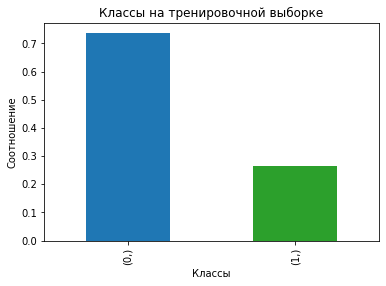

In [137]:
class_frequency = target_train.value_counts(normalize=True)
print('Баланс классов на тренировочной выборке: ')
print(class_frequency)
class_frequency.plot(kind='bar', color=['C0', 'C2'])
plt.xlabel('Классы')
plt.ylabel('Соотношение')
plt.title('Классы на тренировочной выборке')
plt.show()

Баланс классов на тестовой выборке: 
0    0.678559
1    0.321441
dtype: float64


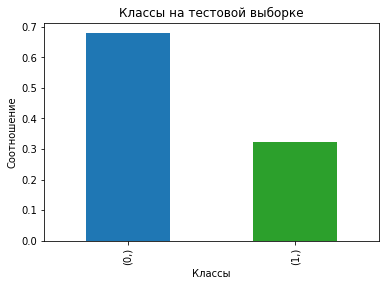

In [138]:
class_frequency = target_test.value_counts(normalize=True)
print('Баланс классов на тестовой выборке: ')
print(class_frequency)
class_frequency.plot(kind='bar', color=['C0', 'C2'])
plt.xlabel('Классы')
plt.ylabel('Соотношение')
plt.title('Классы на тестовой выборке')
plt.show()

В среднем классы 0 и 1 встречаются в соотношении 6 к 4 (или 3 к 2) соответственно.

Сравним качество модели дерева решений  до устранения дисбаланса с качеством константной модели

In [139]:
f1_best = 0
precision_best = 0
recall_best = 0
best_result = 0
target_sample = 0

for depth in tqdm(range(10, 31, 10)):
    for leaf_samples in range(2, 20):
        kf = KFold(n_splits=2, random_state=12345, shuffle=True)
        
        all_preds = []
        all_targs = []
        
        all_preds_nonprob = []
        all_targs_nonprob = []
        
        destree_params = {
            'random_state': 12345,
            'max_depth' : depth,
            'min_samples_leaf' : leaf_samples
        }
        
        for train_index, test_index in kf.split(features_train):
            train_X = numpy.array(features_train)[train_index]
            test_X = numpy.array(features_train)[test_index]
            
            train_y = numpy.array(target_train)[train_index]
            test_y = numpy.array(target_train)[test_index]
            DecisionTree_model = DecisionTreeClassifier(**destree_params)
            DecisionTree_model.fit(train_X, train_y.flatten())
        
            predicted = DecisionTree_model.predict_proba(test_X)[:, 1]
            predictions = DecisionTree_model.predict(test_X)
   
            all_preds.append(predicted)
            all_targs.append(test_y)
        
            all_preds_nonprob.append(predictions)
            all_targs_nonprob.append(test_y)
            
        all_preds = numpy.concatenate(all_preds, axis=0).flatten()
        all_targs = numpy.concatenate(all_targs, axis=0).flatten()
        
        all_preds_nonprob = numpy.concatenate(all_preds_nonprob, axis=0).flatten()
        all_targs_nonprob = numpy.concatenate(all_targs_nonprob, axis=0).flatten()
        
        result = roc_auc_score(all_targs, all_preds)
        if result > best_result:
            best_result = result
        
        f1 = recall_score(all_targs_nonprob, all_preds_nonprob)
        precision = precision_score(all_targs_nonprob, all_preds_nonprob)
        recall = recall_score(all_targs_nonprob, all_preds_nonprob)
        
        if f1_best < f1:
            f1_best = f1
        if precision_best < precision:
            precision_best = precision
        if recall_best < recall:
            recall_best = recall
        target_sample = test_y

100%|██████████| 3/3 [01:05<00:00, 21.90s/it]


In [140]:
print('Качество модели дерева решений с дисбалнсом:', best_result)

Качество модели дерева решений с дисбалнсом: 0.8132916776268004


In [141]:
target_pred_constant = numpy.zeros(target_test.shape).astype(int)
accuracy_const = roc_auc_score(target_test, target_pred_constant)
print('Качество константной модели:', accuracy_const)

Качество константной модели: 0.5


Качество модели дерева решений лучше качества константной при несбалансированных данных.

#### Выбор метрики качества моделей

Рассчитаю матрицу ошибок функцией confusion_matrix(), матрица ошибок поможет выбрать метрики.

In [142]:
print(confusion_matrix(target_sample, predictions))

[[13823  1321]
 [ 2894  2576]]


**Правильные прогнозы:**
* TN (Истинно отрицательные ответы) в левом верхнем углу - 13823  клиентов не отменяли бронь, как и предсказала модель;
* TP (Истинно положительные ответы) в правом нижнем углу - 2576 клиентов действительно отменили бронь, и модель предсказала также.

**Ошибочные варианты:**
* FP (Ложно положительные ответы)  в правом верхнем углу  - Модель предсказала, что 1321 клиентов отменят бронь, а они приехали;
* FN (Ложно отрицательные ответы) в левом нижнем углу. - 2894  клиентов подтвердили бронь по мнению модели, тогда как они на самом деле отменили её. 

In [143]:
print("Доля правильных ответов, найденных моделью:", recall_best)

Доля правильных ответов, найденных моделью: 0.5176999266324285


Полнота очень плохая, посмотрим на точность - как много отрицательных ответов нашла модель, пока искала положительные.

In [144]:
print("Точность предсказания положительных ответов:", precision_best)

Точность предсказания положительных ответов: 0.6744907594765952


Точность получше, но все равно модель плохо предсказывает положительные классы. 
Если положительный класс плохо прогнозируется по одной из шкал (Recall или Precision), то близкая к нулю F1-мера покажет, что прогноз класса 1 не удался:

In [145]:
print(f1_best)

0.5176999266324285


Плохая по всем метрикам - нужно устранять дисбаланс классов.

Матрица ошибок показала большое количество ложноотрицательных ответов - это значит, что клиенты отменят запись, а модель посчитала, что клиенты приедут. Это плохо, т.к. в таком случае отель понесет убытки.

На первый взгляд кажется, что задача сводится к бинарной классификации с метками 1, если клиент отменил бронь в отеле, и меткой 0  – если оставил бронь.

Однако если копнуть глубже, то окажется, что такие метки практически бесполезны. Гостинице больше интересно упорядрчить клиентов по вероятностям отмены предполагаемого бронирования, и в зависимости от этого решить, целесообразно ли требовать вперед депозит для создания брони клиенту или нет. 

Так как в задаче важна не метка сама по себе, а правильный порядок на объектах, имеет смысл применять метрику **AUC ROC**.

Для задачи двоичной классификации при определении классов случайным образом, можно получить 0.5 AUC. Следовательно, если это задача бинарной классификации, разумное значение AUC должно быть > 0.5.

Обучу модель логистической регрессии на несбалансированных данных, чтобы посмотреть, как изменится метрика после балансировки:

In [146]:
best_result = 0

for ratio in tqdm(numpy.linspace(0, 1, 3)):
    for c in range(-5, 5):
        kf = KFold(n_splits=2, random_state=12345, shuffle=True)
        
        all_preds = []
        all_targs = []
        
        logreg_params = {
            'C': 10**c, 
            'l1_ratio': ratio, 
            'solver': 'saga', 
            'penalty': 'elasticnet',
            'random_state': 12345
        }
        
        for train_index, test_index in kf.split(features_train):
            train_X = numpy.array(features_train)[train_index]
            test_X = numpy.array(features_train)[test_index]
            
            train_y = numpy.array(target_train)[train_index]
            test_y = numpy.array(target_train)[test_index]
            model_LogisticR_disbalanced= LogisticRegression(**logreg_params)
            model_LogisticR_disbalanced.fit(train_X, train_y.flatten())
            
            predicted = model_LogisticR_disbalanced.predict_proba(test_X)[:, 1]
            
            all_preds.append(predicted)
            all_targs.append(test_y)
            
        all_preds = numpy.concatenate(all_preds, axis=0).flatten()
        all_targs = numpy.concatenate(all_targs, axis=0).flatten()
        
        result = roc_auc_score(all_targs, all_preds)
        if result > best_result:
            best_result = result

print("AUC несбалансированной модели логистической регрессии:", best_result) 

  0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was r

AUC несбалансированной модели логистической регрессии: 0.7748479738099738


Разделю обучающую выборку на отрицательные и положительные объекты:

* features_zeros — признаки объектов с ответом «0»;
* features_ones — признаки объектов с ответом «1»;
* target_zeros — целевой признак объектов, у которых ответы только «0»;
* target_ones — целевой признак объектов, у которых ответы только «1».

In [147]:
print(features_train.shape)
print(target_train.shape)

(41228, 306)
(41228, 1)


In [148]:
display(features_train.head(3))
display((target_train == 0).head(3))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305
0,-0.829365,-1.788312,-0.271827,-0.09269,-0.100507,-0.364744,-0.076647,-0.851485,-1.192040,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.733904,0.254199,-0.271827,-0.09269,-0.100507,-0.364744,-0.076647,0.386569,-0.661621,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.924826,0.254199,-0.271827,-0.09269,-0.100507,-0.364744,-0.076647,-0.851485,-0.661621,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0

,0
0,True
1,True
2,True


In [149]:
features_zeros = features_train[target_train[0] == 0]
features_ones = features_train[target_train[0] == 1]
target_ones = target_train[target_train[0] == 1]
target_zeros = target_train[target_train[0] == 0]

print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(30324, 306)
(10904, 306)
(30324, 1)
(10904, 1)


Продублирую объекты положительного класса и объединю их с объектами отрицательного класса:

In [150]:
print('Соотношение классов "0" к "1":', len(features_zeros) / len(features_ones))

Соотношение классов "0" к "1": 2.780997798972854


### Обучение моделей на готовых данных

Обучаю модель логистической регрессии:

In [151]:
best_scores_list_auc_roc = []
best_models_list_auc_roc = []
best_params_list_auc_roc = []

In [152]:
best_result = 0
best_logreg_params = {}
best_ratio = 0
best_c = 0
best_model = None
LogisticR_model = None


for ratio in tqdm(numpy.linspace(0, 1, 3)):
    for c in range(-5, 5):
        kf = KFold(n_splits=2, random_state=12345, shuffle=True)
        
        all_preds = []
        all_targs = []
        
        logreg_params = {
            'C': 10**c, 
            'l1_ratio': ratio, 
            'solver': 'saga', 
            'penalty': 'elasticnet',
            'random_state': 12345,
            'class_weight' : 'balanced'
        }
        
        for train_index, test_index in kf.split(features_train):
            train_X = numpy.array(features_train)[train_index]
            test_X = numpy.array(features_train)[test_index]
            
            train_y = numpy.array(target_train)[train_index]
            test_y = numpy.array(target_train)[test_index]
            model_LogisticR= LogisticRegression(**logreg_params)
            model_LogisticR.fit(train_X, train_y.flatten())
            
            predicted_test = model_LogisticR.predict_proba(test_X)[:, 1]
            
            all_preds.append(predicted_test)
            all_targs.append(test_y)
            
        all_preds = numpy.concatenate(all_preds, axis=0).flatten()
        all_targs = numpy.concatenate(all_targs, axis=0).flatten()
        
        result = roc_auc_score(all_targs, all_preds)
        if result > best_result:
            best_result = result
            best_logreg_params = logreg_params
            best_model = model_LogisticR

LogisticR_model = best_model          

best_scores_list_auc_roc.append(best_result)
best_models_list_auc_roc.append(best_model)
best_params_list_auc_roc.append(best_model.get_params())

print('Модель логистической регрессии обучена!')
print('AUC ROC метрика для модели логистической регресии со взвешенными классами:', best_result)
print('Best params', best_logreg_params)
print('Лучшая модель:', best_model)

  0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was r

Модель логистической регрессии обучена!
AUC ROC метрика для модели логистической регресии со взвешенными классами: 0.7766217719744394
Best params {'C': 0.1, 'l1_ratio': 0.5, 'solver': 'saga', 'penalty': 'elasticnet', 'random_state': 12345, 'class_weight': 'balanced'}
Лучшая модель: LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.5,
                   penalty='elasticnet', random_state=12345, solver='saga')


Обучаю модели дерева решений:

In [153]:
best_result = 0
best_destree_params = {}
best_depth = 0
best_model = None
model_DecisionTree = None

for depth in tqdm(range(10, 31, 10)):
    for leaf_samples in range(2, 20):
        kf = KFold(n_splits=2, random_state=12345, shuffle=True)
        
        all_preds = []
        all_targs = []
        
        destree_params = {
            'random_state': 12345,
            'class_weight' : 'balanced',
            'max_depth' : depth,
            'min_samples_leaf' : leaf_samples
        }
        
        for train_index, test_index in kf.split(features_train):
            train_X = numpy.array(features_train)[train_index]
            test_X = numpy.array(features_train)[test_index]
            
            train_y = numpy.array(target_train)[train_index]
            test_y = numpy.array(target_train)[test_index]
            DecisionTree_model = DecisionTreeClassifier(**destree_params)
            DecisionTree_model.fit(train_X, train_y.flatten())
        
            predicted_test = DecisionTree_model.predict_proba(test_X)[:, 1]
            
            all_preds.append(predicted_test)
            all_targs.append(test_y)
            
        all_preds = numpy.concatenate(all_preds, axis=0).flatten()
        all_targs = numpy.concatenate(all_targs, axis=0).flatten()
        
        result = roc_auc_score(all_targs, all_preds)
        if result > best_result:
            best_result = result
            best_destree_params = destree_params
            best_model = DecisionTree_model
            
model_DecisionTree = best_model

best_scores_list_auc_roc.append(best_result)
best_models_list_auc_roc.append(best_model)
best_params_list_auc_roc.append(best_model.get_params())


print('Модель дерева решений обучена!')
print('AUC ROC метрика для модели дерева решений со взвешенными классами:', best_result)
print('Best params', best_destree_params)
print('Лучшая модель:', best_model)

100%|██████████| 3/3 [01:04<00:00, 21.53s/it]

Модель дерева решений обучена!
AUC ROC метрика для модели дерева решений со взвешенными классами: 0.8173775544370252
Best params {'random_state': 12345, 'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 17}
Лучшая модель: DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=17, random_state=12345)


Обучаю модель случайного леса

In [154]:
best_result = 0
best_randfor_params = {}
best_depth = 0
best_est = 0
best_model = None
model_RandomForest = None

for depth in tqdm(range(10, 31, 10)):
    for est in range(10, 31, 10):
            kf = KFold(n_splits=2, random_state=12345, shuffle=True)

            all_preds = []
            all_targs = []

            randfor_params = {
                'random_state': 12345,
                'class_weight' : 'balanced',
                'max_depth' : depth,
                'n_estimators' : est
            }

            for train_index, test_index in kf.split(features_train):
                train_X = numpy.array(features_train)[train_index]
                test_X = numpy.array(features_train)[test_index]

                train_y = numpy.array(target_train)[train_index]
                test_y = numpy.array(target_train)[test_index]
                RandomForest_model = RandomForestClassifier(**destree_params)
                RandomForest_model.fit(train_X, train_y.flatten())

                predicted_test = RandomForest_model.predict_proba(test_X)[:, 1]

                all_preds.append(predicted_test)
                all_targs.append(test_y)

            all_preds = numpy.concatenate(all_preds, axis=0).flatten()
            all_targs = numpy.concatenate(all_targs, axis=0).flatten()

            result = roc_auc_score(all_targs, all_preds)
            if result > best_result:
                best_result = result
                best_randfor_params = randfor_params
                best_model = RandomForest_model
            
model_RandomForest = best_model

best_scores_list_auc_roc.append(best_result)
best_models_list_auc_roc.append(best_model)
best_params_list_auc_roc.append(best_model.get_params())

print('Модель случайного леса обучена!')
print('AUC ROC метрика для модели случайного леса со взвешенными классами:', best_result)
print('Best params', best_randfor_params)

100%|██████████| 3/3 [01:02<00:00, 20.74s/it]

Модель случайного леса обучена!
AUC ROC метрика для модели случайного леса со взвешенными классами: 0.8381993575522775
Best params {'random_state': 12345, 'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 10}


In [155]:
model_of_hiest_score_auc_roc = 0
hiest_score_auc_roc = 0
for index in range(len(best_scores_list_auc_roc)):
    if best_scores_list_auc_roc[index] > hiest_score_auc_roc:
        hiest_score_auc_roc = best_scores_list_auc_roc[index]
        model_of_hiest_score_auc_roc = best_models_list_auc_roc[index]
        
print('Лучшая метрика AUC ROC =', hiest_score_auc_roc, 'у модели', model_of_hiest_score_auc_roc)

Лучшая метрика AUC ROC = 0.8381993575522775 у модели RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=19, random_state=12345)


In [156]:
print(best_models_list_auc_roc)

[LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.5,
                   penalty='elasticnet', random_state=12345, solver='saga'), DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=17, random_state=12345), RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=19, random_state=12345)]


In [157]:
best_models_df_auc_roc = pd.DataFrame(best_models_list_auc_roc)
best_models_df_auc_roc = best_models_df_auc_roc.rename(columns={0 : 'model'})

best_params_list_auc_roc = pd.DataFrame(best_params_list_auc_roc)

best_scores_df_auc_roc = pd.DataFrame(best_scores_list_auc_roc)
best_scores_df_auc_roc = best_scores_df_auc_roc.rename(columns={0 : 'roc_auc_score'})

df_models_and_scores = pd.concat([best_scores_df_auc_roc,best_params_list_auc_roc], axis=1)
df_models_and_scores = df_models_and_scores.rename(index={0: 'Логистическая регрессия', 1: 'Дерево решений', 2: 'Случайный лес'})
df_models_and_scores = df_models_and_scores.fillna('-')
display(df_models_and_scores)

,roc_auc_score,C,class_weight,dual,fit_intercept,intercept_scaling,l1_ratio,max_iter,multi_class,n_jobs,penalty,random_state,solver,tol,verbose,warm_start,ccp_alpha,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_impurity_split,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,splitter,bootstrap,max_samples,n_estimators,oob_score
Логистическая регрессия,0.776622,0.1,balanced,False,True,1.0,0.5,100.0,auto,-,elasticnet,12345,saga,0.0001,0.0,False,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
Дерево решений,0.817378,-,balanced,-,-,-,-,-,-,-,-,12345,-,-,-,-,0.0,gini,10.0,-,-,0.0,-,17.0,2.0,0.0,best,-,-,-,-
Случайный лес,0.838199,-,balanced,-,-,-,-,-,-,-,-,12345,-,-,0.0,False,0.0,gini,30.0,auto,-,0.0,-,19.0,2.0,0.0,-,True,-,100.0,False


### Оценка прибыли на предсказанных данных

Функция для расчета прибыли после внедрения депозита:

In [158]:
df_test.head()

,arrival_date_month,meal,country,distribution_channel,reserved_room_type,customer_type,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,seasonal_room_cost,season_room_service,profit_before_deposit
0,January,BB,PRT,TA/TO,A,Transient,6086,1,74,2017,1,1,1,0,2,0,0.0,0,0,0,0,0,0,0,1,1000.0,400.0,-1400.0
2,January,BB,AUT,TA/TO,A,Transient,6088,1,62,2017,1,1,2,2,2,0,0.0,0,0,0,0,0,0,1,4,1000.0,400.0,-1400.0
3,January,BB,PRT,TA/TO,A,Transient,6089,1,71,2017,1,1,2,2,1,0,0.0,0,0,0,0,0,0,1,4,1000.0,400.0,-1400.0
4,January,BB,BEL,TA/TO,A,Transient,6090,1,172,2017,1,1,2,5,2,0,0.0,0,0,0,0,0,0,0,7,1000.0,400.0,-1400.0
5,January,BB,DEU,TA/TO,A,Transient,6091,1,52,2017,1,1,2,5,1,0,0.0,0,0,0,0,0,0,0,7,1000.0,400.0,-1400.0


Изучу, какая модель предсказывает наибольшую прибыль.

In [159]:
def predicted_profit(line):

    if (line['is_cancelled_predicted'] > 0.5 and line['is_canceled'] == 1):
        revenue = line['seasonal_room_cost'] * 0.8
        expenses = -line['season_room_service'] * 0.8
    
    elif (line['is_cancelled_predicted'] < 0.5 and line['is_canceled'] == 0):
        revenue = line['seasonal_room_cost'] * line['total_nights'] 
        expenses = line['season_room_service'] * (1 + line['total_nights'] // 2)
        
    elif (line['is_cancelled_predicted'] > 0.5 and line['is_canceled'] == 0):
        revenue = line['seasonal_room_cost'] * line['total_nights'] 
        expenses = line['season_room_service'] * (1 + line['total_nights'] // 2)
    
    elif (line['is_cancelled_predicted'] < 0.5 and line['is_canceled'] == 1):
        revenue = -line['seasonal_room_cost']
        expenses = line['season_room_service']
        
    result = revenue - expenses

    return result



**1) Прибыль согласно предсказанных значений модели случайного леса:**

In [160]:
model = model_RandomForest
predicted_test = model.predict_proba(features_test)[:, 1]
print('Качество модели на тестовой выборке', roc_auc_score(target_test, predicted_test))
print('AUC ROC метрика на кросс-валидации: 0.8381993575522775')
df_test['is_cancelled_predicted'] = predicted_test

df_test['profit_after_deposit'] = df_test.apply(predicted_profit, axis=1)

#итоговая прибыль
display('Пример предполагаемой прибыли, если бронь подтверждена:', df_test[df_test['is_canceled'] == 0]['profit_after_deposit'].head())
display('Пример предполагаемой прибыли, если бронь отменена:', df_test[df_test['is_canceled'] == 1]['profit_after_deposit'].head())

Качество модели на тестовой выборке 0.7435213870939492
AUC ROC метрика на кросс-валидации: 0.8381993575522775


'Пример предполагаемой прибыли, если бронь подтверждена:'

95       600.0
299     2800.0
2041     840.0
2125    2200.0
2126     600.0
Name: profit_after_deposit, dtype: float64

'Пример предполагаемой прибыли, если бронь отменена:'

0    1120.0
2   -1400.0
3    1120.0
4   -1400.0
5   -1400.0
Name: profit_after_deposit, dtype: float64

In [177]:
display(df_test[df_test['is_canceled'] == 1].head())

,arrival_date_month,meal,country,distribution_channel,reserved_room_type,customer_type,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,seasonal_room_cost,season_room_service,profit_before_deposit,is_cancelled_predicted,profit_after_deposit
0,January,BB,PRT,TA/TO,A,Transient,6086,1,74,2017,1,1,1,0,2,0,0.0,0,0,0,0,0,0,0,1,1000.0,400.0,-1400.0,0.707848,1120.0
2,January,BB,AUT,TA/TO,A,Transient,6088,1,62,2017,1,1,2,2,2,0,0.0,0,0,0,0,0,0,1,4,1000.0,400.0,-1400.0,0.198243,-1400.0
3,January,BB,PRT,TA/TO,A,Transient,6089,1,71,2017,1,1,2,2,1,0,0.0,0,0,0,0,0,0,1,4,1000.0,400.0,-1400.0,0.547823,1120.0
4,January,BB,BEL,TA/TO,A,Transient,6090,1,172,2017,1,1,2,5,2,0,0.0,0,0,0,0,0,0,0,7,1000.0,400.0,-1400.0,0.527393,1120.0
5,January,BB,DEU,TA/TO,A,Transient,6091,1,52,2017,1,1,2,5,1,0,0.0,0,0,0,0,0,0,0,7,1000.0,400.0,-1400.0,0.282361,-1400.0


In [161]:
print('Прибыль до внедрения депозита:              ', df_test['profit_before_deposit'].sum())
print('Возможная прибыль после внедрения депозита: ', df_test['profit_after_deposit'].sum())

Прибыль до внедрения депозита:               27841160.0
Возможная прибыль после внедрения депозита:  36148754.0


**2) Прибыль на основании предсказанных значений модели дерева решений:**

In [162]:
model = model_DecisionTree
predicted_test = model.predict_proba(features_test)[:, 1]
df_test['is_cancelled_predicted'] = predicted_test
print('Качество модели на тестовой выборке', roc_auc_score(target_test, predicted_test))
print('AUC ROC метрика на кросс-валидации: 0.8173775544370252')

Качество модели на тестовой выборке 0.7269271313829533
AUC ROC метрика на кросс-валидации: 0.8173775544370252


In [163]:
df_test['profit_after_deposit'] = df_test.apply(predicted_profit, axis=1)

In [164]:
print('Прибыль до внедрения депозита:              ', df_test['profit_before_deposit'].sum())
print('Возможная прибыль после внедрения депозита: ', df_test['profit_after_deposit'].sum())


Прибыль до внедрения депозита:               27841160.0
Возможная прибыль после внедрения депозита:  38357894.0


**3) Прибыль на основании предсказанных значений модели логистической регрессии:**

In [165]:
model = LogisticR_model
predicted_test = model.predict_proba(features_test)[:, 1]
df_test['is_cancelled_predicted'] = predicted_test
print('Качество модели на тестовой выборке', roc_auc_score(target_test, predicted_test))
print('AUC ROC метрика на кросс-валидации: 0.7766217719744394')

Качество модели на тестовой выборке 0.7359812841013853
AUC ROC метрика на кросс-валидации: 0.7766217719744394


In [166]:
df_test['profit_after_deposit'] = df_test.apply(predicted_profit, axis=1)

In [167]:
print('Прибыль до внедрения депозита:              ', df_test['profit_before_deposit'].sum())
print('Возможная прибыль после внедрения депозита: ', df_test['profit_after_deposit'].sum())


Прибыль до внедрения депозита:               27841160.0
Возможная прибыль после внедрения депозита:  40490030.0


Согласно условиям задания, общий бюджет на разработку системы не должен превышать прибыль от внедрения депозита по рекомендации модели за тестовый период. Все три модели предсказали прибыль больше бюджета на внедрение, наиболе прибыльная - модель логистической регрессии.

### Вывод

Были обучены три модели: логистическая регрессия, дерево решений и случайный лес. Была выбрана метрика качесва ACU ROC как наиболее релевантная данной задаче. Все модели показали приемлемые метрики каества, наибольшее качество показала модель случайного леса, но наибольшая предсказанная прибыль получилась на данных модели **логистической регрессии**, а также разрыв качества модели логистической регрессии на тестовой выборке и на тренировочном датасете наименьший - поэтому рекомендуется использовать логистическую модель для предсказания поведения клиентов. 

## Шаг . Опишите портрет «ненадёжного» клиента

In [168]:
model = LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=1.0, penalty='elasticnet', random_state=12345, solver='saga')
model.fit(features_train, target_train)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=1.0,
                   penalty='elasticnet', random_state=12345, solver='saga')

In [169]:
print(features_train.shape)

(41228, 306)


In [170]:
print(model.coef_.shape)

(1, 306)


Индексы весов признаков, упорядоченные

In [171]:
features_order = model.coef_.argsort()

hashed_colnames = numpy.array(hashed_colnames)

print(hashed_colnames[features_order[0, :10]], '<- Весомые признаки класса 0')
print()
print(hashed_colnames[features_order[0, -10:]], '<- Весомые признаки класса 1')

['arrival_date_year_2015' 'country_DEU' 'country_AUT' 'country_GBR'
 'country_FRA' 'country_NLD' 'distribution_channel_Direct' 'country_IRL'
 'previous_bookings_not_canceled' 'arrival_date_month_January'] <- Весомые признаки класса 0

['country_RUS' 'country_ITA' 'meal_SC' 'distribution_channel_TA/TO'
 'customer_type_Transient' 'country_TUR' 'previous_cancellations'
 'country_CHN' 'country_AGO' 'country_PRT'] <- Весомые признаки класса 1


**Портрет самого ненадежного клиента согласно наиболее эффескивной модели:**

* Туристы из России, Италии, Турции, Китая, Анголы и Португалии
* Не заказывающие питание в отеле (SC)
* Канал дистрибуции заказа - TA/TO
* Тип заказа не связан с договором или групповым заездом
* Когда-либо отменяли бронирования

Самый надежный клиент выглядит как:

* Из Германии, Австрии, Великобритании, Франции, Нидерландов, Ирландии
* Канал дистрибуции - Direct
* Имеет подтвержденные брони в прошлом
* Заселявшиеся в январе 2015 года

Для того, чтобы убедиться в првильности описания ненадежного клиента, изучу веса признаков случайного леса

In [172]:
model = RandomForestClassifier(class_weight='balanced', max_depth=30, min_samples_leaf=19, random_state=12345)
model.fit(features_train, target_train)
print('Значения весов, на которые домножаются признаки:', model.feature_importances_)

/tmp/ipykernel_442/3072522856.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(features_train, target_train)


Значения весов, на которые домножаются признаки: [1.72513270e-01 1.05680626e-02 5.30415032e-03 5.11553971e-02
 1.99192745e-02 3.30933972e-02 1.90900385e-03 1.28779543e-01
 2.85398711e-02 3.10574024e-02 3.34925234e-02 3.39419825e-05
 2.88417358e-04 9.85472162e-05 2.38391246e-04 1.09281675e-04
 3.58828043e-04 3.56240611e-04 5.45454879e-04 3.56238485e-04
 5.46841435e-04 5.65100230e-04 5.60754354e-04 6.36826627e-04
 2.68217929e-04 3.81563490e-04 5.56084349e-04 2.80569892e-04
 5.33695569e-04 2.18109629e-04 4.63491409e-04 6.19646729e-04
 2.41547507e-04 3.94634503e-04 2.66527010e-04 4.00944739e-04
 2.28072138e-04 6.54001776e-04 5.54778670e-04 5.69911711e-04
 5.32712679e-04 3.96186063e-04 4.88588291e-04 6.02983048e-04
 4.83280235e-04 5.67552682e-04 4.85217915e-04 7.46170251e-04
 6.28775567e-04 6.95606391e-04 3.44379935e-04 7.26838061e-04
 6.87322004e-04 9.50143214e-04 9.32102539e-04 6.09011429e-04
 8.33475928e-04 9.06092511e-04 6.23888983e-04 5.93177620e-04
 1.26182896e-03 4.25265388e-04 3.375

In [173]:
print(features_train.shape)

print(model.feature_importances_.shape)

(41228, 306)
(306,)


In [174]:
features_order = model.feature_importances_.argsort()
print(features_order.shape)

hashed_colnames = numpy.array(hashed_colnames)
print(hashed_colnames.shape)

# print(hashed_colnames[features_order[0:10]])
# print(hashed_colnames[features_order[-10:]], '<- Весомые признаки класса 0')

print(hashed_colnames[features_order[0:10]], '<- Весомые признаки класса 0')
print()
print(hashed_colnames[features_order[-10:]], '<- Весомые признаки класса 1')

(306,)
(306,)
['country_ECU' 'country_CUB' 'country_CYM' 'country_CYP' 'country_SYR'
 'country_DMA' 'country_DOM' 'country_DZA' 'country_EGY' 'country_EST'] <- Весомые признаки класса 0

['country_FRA' 'total_nights' 'arrival_date_year_2015' 'booking_changes'
 'arrival_date_year_2016' 'distribution_channel_TA/TO'
 'previous_cancellations' 'country_PRT' 'total_of_special_requests'
 'lead_time'] <- Весомые признаки класса 1


Ненадежные клиенты согласно предсказаниям модели случайного леса:

* Граждане Франции и Португалии
* Заселявшиеся в 2015 и 2016 годах
* Вносившие изменения в бронь
* Канал дистрибуции TA/TO
* В прошлом отменяли бронирование
* Имеют специальные отметки
* Бронируют заранее

In [175]:
model = DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_leaf=17, random_state=12345)
model.fit(features_train, target_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=17, random_state=12345)

In [176]:
features_order = model.feature_importances_.argsort()

hashed_colnames = numpy.array(hashed_colnames)

print(hashed_colnames[features_order[:10]], '<- Весомые признаки класса 0')
print()
print(hashed_colnames[features_order[-10:]], '<- Весомые признаки класса 1')

['country_ECU' 'country_JOR' 'country_JPN' 'country_KAZ' 'country_KEN'
 'country_KHM' 'country_KNA' 'country_KOR' 'country_KWT' 'country_LBN'] <- Весомые признаки класса 0

['total_nights' 'booking_changes' 'distribution_channel_TA/TO'
 'previous_bookings_not_canceled' 'previous_cancellations'
 'customer_type_Transient' 'total_of_special_requests'
 'arrival_date_year_2016' 'country_PRT' 'lead_time'] <- Весомые признаки класса 1


Ненадежные клиенты согласно предсказаниям модели дерева решений:

* Вносившие изменения в брони
* Канал дистрибуции TA/TO
* Заселявшиеся ранее
* Ранее отменявшие брони
* ТИп заказчика - Transient
* Имеют специальные отметки
* Бронировавшие в 2016 году
* Из Португалии
* Бронирующие заранее


## Шаг . Напишите общий вывод

В ходе исследования быыли изучены и предобработаны данные, содержащие информацию о поведении клиентов сети отелей «Как в гостях». Рассчитан доход и затраты с каждого клиента с учетом сезонных колебаний стоимости, посчитана прибыль отеля за тесовый период до внедрения системы депозита. Данные подготовлены к обучению и обучены три модели машинного обучения - логистическая регрессия, дерево решений и случайный лес,- модели предсказывают отмену брони на основании имеющихся данных о клиентах. Все три модели показали относительно приемлемое качество метрики AUC ROC больше 0.5 (с учетом отсутствия критериев по данной метрике выбран данный порог) Наиболее эффективной с точки зрения прибыльности показала себя **модель линейной регрессии** - таким образом, данная модель рекомендуется к развертыванию. Однако все модели оказались прибыльными в той или инной степени. 

Усредненный портрет ненадежного клиента:

* Туристы из Португалии
* Бронировавшие в 2016 году
* Вносившие изменения в бронь
* Канал дистрибуции заказа - TA/TO
* Тип заказа не связан с договором или групповым заездом
* Когда-либо отменяли бронирования
* Имеют специальные отметки
* Бронируют заранее

